In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
np.random.seed(2021)

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
train_df = pd.read_csv("/content/imputed_train_whole_file.csv")
test_df = pd.read_csv("/content/imputed_test_whole_file.csv")

In [5]:
df = train_df.copy()
df = df.append(test_df)

In [6]:
neg, pos = np.bincount(df["y_true"])

In [7]:
total = neg + pos
print('Data Class count:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Data Class count:
    Total: 17917
    Positive: 2361 (13.18% of total)



In [8]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [9]:
train_labels = np.array(train_df.pop('y_true'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('y_true'))
test_labels = np.array(test_df.pop('y_true'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [10]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (11466,)
Validation labels shape: (2867,)
Test labels shape: (3584,)
Training features shape: (11466, 85)
Validation features shape: (2867, 85)
Test features shape: (3584, 85)


In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
rf_base = RandomForestClassifier()

In [13]:
rf_base.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
base_prediction = rf_base.predict(test_features)

In [15]:
base_prob_train = rf_base.predict_proba(train_features)

In [16]:
base_prob = rf_base.predict_proba(test_features)

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix

In [18]:
base_cm = confusion_matrix(test_labels, base_prediction)
print(base_cm)

[[3067   50]
 [ 383   84]]


In [19]:
# Pos label = 1
print("precison:")
print(precision_score(test_labels, base_prediction))
print("recall:")
print(recall_score(test_labels, base_prediction))
print("AUC:")
print(roc_auc_score(test_labels, base_prob[:, 1]))
print("F1:")
print(f1_score(test_labels, base_prediction))

precison:
0.6268656716417911
recall:
0.17987152034261242
AUC:
0.8316790770239051
F1:
0.27953410981697174


In [20]:
# Pos label = 0
print("precison:")
print(precision_score(test_labels, base_prediction, pos_label=0))
print("recall:")
print(recall_score(test_labels, base_prediction, pos_label=0))
print("F1:")
print(f1_score(test_labels, base_prediction, pos_label=0))

precison:
0.8889855072463768
recall:
0.9839589348732756
F1:
0.9340642606974265


In [21]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-5, 105])
  plt.ylim([-5, 105])
  plt.grid(True)

In [22]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

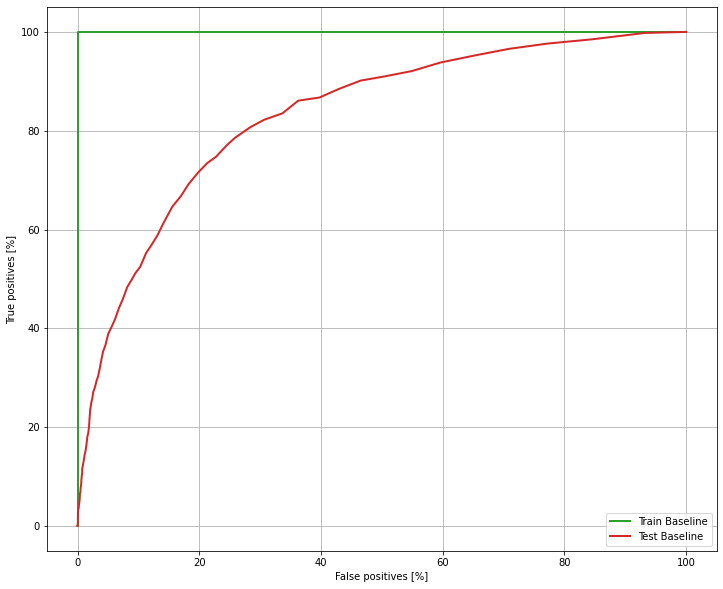

In [24]:
plot_roc("Train Baseline", train_labels, base_prob_train[:, 1], color=colors[2])
plot_roc("Test Baseline", test_labels, base_prob[:, 1], color=colors[3])
plt.legend()

We can see that the over fitting problem is pretty obvious

### Parameters Tunning

In [30]:
rf_base = RandomForestClassifier()
rf_base.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in the random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each treee
bootstrap = [True, False]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Create random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


#### Random Search Cross Validation

In [46]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using a 4 fold cross validation
# Search across 150 different combinations, and use all available cores
scoring = {"Recall":"recall", "AUC":"roc_auc"}
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = random_grid, n_iter = 60, cv = 4, verbose=60, random_state=2021, n_jobs = -1, scoring="roc_auc")

# Fit the random search model
rf_random.fit(train_features_over, train_labels_over)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 13.5min


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 31.0min
[Paralle

RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# The best random forest estimator now, picked by random search
best_random = rf_random.best_estimator_.get_param

In [81]:
best_random = RandomForestClassifier(max_depth=10, min_samples_split=120, class_weight="balanced")
best_random.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=120,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [82]:
best_prob_train = best_random.predict_proba(train_features)
best_prob = best_random.predict_proba(test_features)
best_prediction = best_random.predict(test_features)
best_cm = confusion_matrix(test_labels, best_prediction)
print(best_cm)
# Pos label = 1
print("precison:")
print(precision_score(test_labels, best_prediction))
print("recall:")
print(recall_score(test_labels, best_prediction))
print("AUC:")
print(roc_auc_score(test_labels, best_prob[:, 1]))
print("F1:")
print(f1_score(test_labels, best_prediction))

# Pos label = 0
print("precison:")
print(precision_score(test_labels, best_prediction, pos_label=0))
print("recall:")
print(recall_score(test_labels, best_prediction, pos_label=0))
print("F1:")
print(f1_score(test_labels, best_prediction, pos_label=0))

[[2654  463]
 [ 165  302]]
precison:
0.39477124183006534
recall:
0.6466809421841542
AUC:
0.8409640027506821
F1:
0.49025974025974034
precison:
0.941468605888613
recall:
0.8514597369265319
F1:
0.8942048517520216


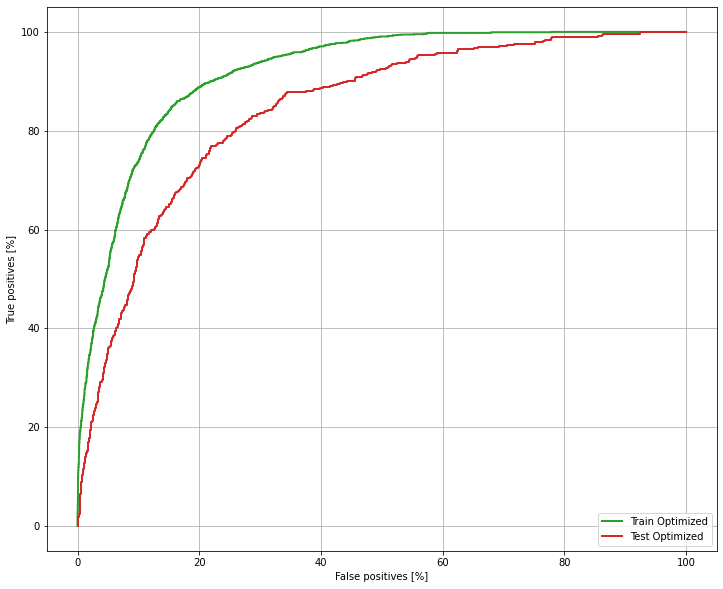

In [86]:
plot_roc("Train Optimized", train_labels, best_prob_train[:, 1], color=colors[2])
plot_roc("Test Optimized", test_labels, best_prob[:, 1], color=colors[3])
plt.legend(loc='lower right')

In [37]:
print("The improvement of AUC is: {}%".format(round(((0.8409640027506821-0.8316790770239051)/0.8316790770239051)*100, 2)))
print("The improvement of Recall(Class 1) is: {}%".format(round(((0.6466809421841542-0.17987152034261242)/0.17987152034261242)*100, 2)))

The improvement of AUC is: 1.12%
The improvement of Recall(Class 1) is: 259.52%


In [35]:
round(((0.8409640027506821-0.8316790770239051)/0.8316790770239051)*100, 2)

1.12

In [38]:
import pickle
filename = "saved_randomforest.sav"
pickle.dump(best_random, open(filename, "wb"))

NameError: ignored